<a href="https://colab.research.google.com/github/samirgadkari/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module1-logistic-regression/LS_DS_231_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Logistic Regression

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models).

## Lecture - Where Linear goes Wrong
### Return of the Titanic 🚢

You've likely already explored the rich dataset that is the Titanic - let's use regression and try to predict survival with it. The data is [available from Kaggle](https://www.kaggle.com/c/titanic/data), so we'll also play a bit with [the Kaggle API](https://github.com/Kaggle/kaggle-api).

In [4]:
!pip install kaggle

In [6]:
# Note - you'll also have to sign up for Kaggle and authorize the API
# https://github.com/Kaggle/kaggle-api#api-credentials

# This essentially means uploading a kaggle.json file
# For Colab we can have it in Google Drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

# You also have to join the Titanic competition to have access to the data
!kaggle competitions download -c titanic

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# How would we try to do this with linear regression?
import pandas as pd

train_df = pd.read_csv('train.csv').dropna()
test_df = pd.read_csv('test.csv').dropna()  # Unlabeled, for Kaggle submission

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In [9]:
from sklearn.linear_model import LinearRegression

X = train_df[['Pclass', 'Age', 'Fare']]
y = train_df.Survived

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.08389810726550917

In [10]:
linear_reg.predict(test_df[['Pclass', 'Age', 'Fare']])

array([0.79543117, 0.58610823, 0.67595121, 0.793829  , 0.62090522,
       0.72542107, 0.59848968, 0.58734245, 0.48567063, 0.77627736,
       0.84211887, 0.57052439, 0.7754689 , 0.96621114, 0.70287941,
       0.57673837, 0.72321391, 0.75894755, 0.77968041, 0.50246003,
       0.49858077, 0.7474959 , 0.3542282 , 0.61648435, 0.71300224,
       0.66294608, 0.53175333, 0.77397395, 0.68419387, 0.68395536,
       0.52041202, 0.56814038, 0.79586606, 0.81372012, 0.61068545,
       0.57260627, 0.52525981, 0.58055388, 0.45584728, 0.67976208,
       0.8226707 , 0.84286197, 0.96189157, 0.66724612, 0.68589478,
       0.61846513, 0.63455044, 0.68275686, 0.65738372, 0.45198998,
       0.59988596, 0.63845908, 0.63132487, 0.7888473 , 0.60126246,
       0.79714045, 0.78713803, 0.54643775, 0.42823635, 0.7711724 ,
       0.53552976, 0.55608044, 0.54480459, 0.57031915, 0.65080369,
       0.77958926, 0.6371013 , 0.70993488, 0.71493598, 0.60375943,
       0.54407206, 0.48186138, 0.76576089, 0.75456305, 0.53968

In [11]:
linear_reg.coef_

array([-0.08596295, -0.00829314,  0.00048775])

In [12]:
import numpy as np

test_case = np.array([[1, 5, 500]])  # Rich 5-year old in first class
linear_reg.predict(test_case)

array([1.14845883])

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X, y)
log_reg.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7103825136612022

In [14]:
log_reg.predict(test_df[['Pclass', 'Age', 'Fare']])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
log_reg.predict(test_case)[0]

1

In [16]:
help(log_reg.predict)

Help on method predict in module sklearn.linear_model.base:

predict(X) method of sklearn.linear_model.logistic.LogisticRegression instance
    Predict class labels for samples in X.
    
    Parameters
    ----------
    X : array_like or sparse matrix, shape (n_samples, n_features)
        Samples.
    
    Returns
    -------
    C : array, shape [n_samples]
        Predicted class label per sample.



In [17]:
log_reg.predict_proba(test_case)[0]

array([0.02485552, 0.97514448])

In [18]:
# What's the math?
log_reg.coef_

array([[-0.0455017 , -0.02912513,  0.0048037 ]])

In [19]:
log_reg.intercept_

array([1.45878264])

In [0]:
# The logistic sigmoid "squishing" function, implemented to accept numpy arrays
def sigmoid(x):
  return 1 / (1 + np.e**(-x))

In [21]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.97514448]])

So, clearly a more appropriate model in this situation! For more on the math, [see this Wikipedia example](https://en.wikipedia.org/wiki/Logistic_regression#Probability_of_passing_an_exam_versus_hours_of_study).

For live - let's tackle [another classification dataset on absenteeism](http://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work) - it has 21 classes, but remember, scikit-learn LogisticRegression automatically handles more than two classes. How? By essentially treating each label as different (1) from some base class (0).

In [0]:
# Live - let's try absenteeism!

## Assignment - real-world classification

We're going to check out a larger dataset - the [FMA Free Music Archive data](https://github.com/mdeff/fma). It has a selection of CSVs with metadata and calculated audio features that you can load and try to use to classify genre of tracks. To get you started:

In [23]:
!pip install -U seaborn
!pip install -U scikit-learn

    100% |████████████████████████████████| 215kB 3.6MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1
  [seaborn]
You must restart the runtime in order to use newly installed versions.
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)


In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

0.9.0


In [2]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip fma_metadata.zip

--2019-01-22 19:17:14--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.13, 2001:620:5ca1:2ff::ce53
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M  15.1MB/s    in 37s     

2019-01-22 19:17:52 (9.24 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]

Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.cs

In [3]:
row1 = ',album,album,album,album,album,album,album,album,album,album,album,album,album,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,set,set,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track'
row2 = ',comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title'
row3 = 'track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,'

print('number of commas in row 1:', row1.count(','))
print('number of commas in row 2:', row2.count(','))
print('number of commas in row 3:', row3.count(','))


number of commas in row 1: 52
number of commas in row 2: 52
number of commas in row 3: 52


In [79]:
!head fma_metadata/tracks.csv

,album,album,album,album,album,album,album,album,album,album,album,album,album,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,set,set,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track
,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,,,"<p>A 

In [0]:
tracks = pd.read_csv('fma_metadata/tracks.csv', header = [0, 1, 2])

In [86]:
tracks.describe()

Unnamed: 0_level_0              album                     \
      Unnamed: 0_level_1           comments          favorites   
                track_id Unnamed: 1_level_2 Unnamed: 5_level_2   
count      106574.000000      106574.000000      106574.000000   
mean        79442.637435           0.394946           1.286927   
std         44704.398384           2.268915           3.133035   
min             2.000000          -1.000000          -1.000000   
25%         40820.250000           0.000000           0.000000   
50%         78983.500000           0.000000           0.000000   
75%        119422.750000           0.000000           1.000000   
max        155320.000000          53.000000          61.000000   

                                                                 \
                      id            listens              tracks   
      Unnamed: 6_level_2 Unnamed: 8_level_2 Unnamed: 12_level_2   
count      106574.000000       1.065740e+05       106574.000000   
mean        12826.933914       3.212031e+04           19.721452   
std          6290.261805       1.478532e+05           39.943673   
min            -1.000000      -1.000000e+00           -1.000000   
25%          7793.000000       3.361000e+03            7.000000   
50%         13374.000000       8.982000e+03           11.000000   
75%         18203.000000       2.363500e+04           17.000000   
max         22940.000000       3.564243e+06          652.000000   

                   artist                                          \
                 comments           favorites                  id   
      Unnamed: 18_level_2 Unnamed: 20_level_2 Unnamed: 21_level_2   
count       106574.000000       106574.000000       106574.000000   
mean             1.894702           30.041915        12036.770404   
std              6.297679          100.511408         6881.420867   
min             -1.000000           -1.000000            1.000000   
25%              0.000000            1.000000         6443.000000   
50%              0.000000            5.000000        12029.500000   
75%              1.000000           16.000000        18011.000000   
max             79.000000          963.000000        24357.000000   

                                                            track  \
                 latitude           longitude            bit_rate   
      Unnamed: 22_level_2 Unnamed: 24_level_2 Unnamed: 33_level_2   
count        44544.000000        44544.000000       106574.000000   
mean            39.901626          -38.668642       263274.695048   
std             18.240860           65.237220        67623.443584   
min            -45.878760         -157.526855           -1.000000   
25%             39.271398          -79.997459       192000.000000   
50%             41.387917          -73.554431       299914.000000   
75%             48.856930            4.351710       320000.000000   
max             67.286005          175.277000       448000.000000   

                                                                   \
                 comments            duration           favorites   
      Unnamed: 34_level_2 Unnamed: 38_level_2 Unnamed: 39_level_2   
count       106574.000000       106574.000000       106574.000000   
mean             0.031621          277.849100            3.182521   
std              0.321993          305.518553           13.513820   
min              0.000000            0.000000            0.000000   
25%              0.000000          149.000000            0.000000   
50%              0.000000          216.000000            1.000000   
75%              0.000000          305.000000            3.000000   
max             37.000000        18350.000000         1482.000000   

                                                                   
                 interest             listens              number  
      Unnamed: 44_level_2 Unnamed: 47_level_2 Unnamed: 49_level_2  
count        1.065740e+05       106574.000000       10657

In [0]:
col_titles = []
for titles in tracks.columns.values:
    ts = list(titles)
    result = ''
    for t in ts:
        if not t.startswith('Unnamed'):
            result += t + ' '
    col_titles.append(result.strip())
    
tracks.columns = col_titles

In [88]:
pd.set_option('display.max_columns', None)  # Unlimited columns
tracks.set_index('track_id', inplace = True)
tracks.head()

,album comments,album date_created,album date_released,album engineer,album favorites,album id,album information,album listens,album producer,album tags,album title,album tracks,album type,artist active_year_begin,artist active_year_end,artist associated_labels,artist bio,artist comments,artist date_created,artist favorites,artist id,artist latitude,artist location,artist longitude,artist members,artist name,artist related_projects,artist tags,artist website,artist wikipedia_page,set split,set subset,track bit_rate,track comments,track composer,track date_created,track date_recorded,track duration,track favorites,track genre_top,track genres,track genres_all,track information,track interest,track language_code,track license,track listens,track lyricist,track number,track publisher,track tags,track title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [89]:
tracks.shape

(106574, 52)

This is the biggest data you've played with so far, and while it does generally fit in Colab, it can take awhile to run. That's part of the challenge!

Your tasks:
- Clean up the variable names in the dataframe
- Use logistic regression to fit a model predicting (primary/top) genre
- Inspect, iterate, and improve your model
- Answer the following questions (written, ~paragraph each):
  - What are the best predictors of genre?
  - What information isn't very useful for predicting genre?
  - What surprised you the most about your results?

*Important caveats*:
- This is going to be difficult data to work with - don't let the perfect be the enemy of the good!
- Be creative in cleaning it up - if the best way you know how to do it is download it locally and edit as a spreadsheet, that's OK!
- If the data size becomes problematic, consider sampling/subsetting
- You do not need perfect or complete results - just something plausible that runs, and that supports the reasoning in your written answers

If you find that fitting a model to classify *all* genres isn't very good, it's totally OK to limit to the most frequent genres, or perhaps trying to combine or cluster genres as a preprocessing step. Even then, there will be limits to how good a model can be with just this metadata - if you really want to train an effective genre classifier, you'll have to involve the other data (see stretch goals).

This is real data - there is no "one correct answer", so you can take this in a variety of directions. Just make sure to support your findings, and feel free to share them as well! This is meant to be practice for dealing with other "messy" data, a common task in data science.

## Try with a partial dataset

In [90]:
tracks.columns.to_series().groupby(tracks.dtypes).groups

{dtype('int64'): Index(['album comments', 'album favorites', 'album id', 'album listens',
        'album tracks', 'artist comments', 'artist favorites', 'artist id',
        'track bit_rate', 'track comments', 'track duration', 'track favorites',
        'track interest', 'track listens', 'track number'],
       dtype='object'),
 dtype('float64'): Index(['artist latitude', 'artist longitude'], dtype='object'),
 dtype('O'): Index(['album date_created', 'album date_released', 'album engineer',
        'album information', 'album producer', 'album tags', 'album title',
        'album type', 'artist active_year_begin', 'artist active_year_end',
        'artist associated_labels', 'artist bio', 'artist date_created',
        'artist location', 'artist members', 'artist name',
        'artist related_projects', 'artist tags', 'artist website',
        'artist wikipedia_page', 'set split', 'set subset', 'track composer',
        'track date_created', 'track date_recorded', 'track genre_top',


### Clean up the dataset

In [0]:
# We will consider -inf and +inf as na values
pd.options.mode.use_inf_as_na = True

### Sample the dataset.  This will give decrease our iteration time.
### Remove rows where 'track genre_top' has null vaues.  Let's see how much data we have left after removal.

In [93]:
tracks_clean = tracks[tracks['track genre_top'].notnull()].copy()
tracks_clean = tracks_clean.sample(2000)

# Drop track/album IDs since that does not have anything to do with track's top genre
tracks_clean.drop(['album id'], axis = 'columns', inplace = True)

print('tracks_clean.shape:', tracks_clean.shape)
tracks_clean.isnull().sum()

tracks_clean.shape: (2000, 51)


album comments                 0
album date_created            51
album date_released          651
album engineer              1677
album favorites                0
album information            454
album listens                  0
album producer              1603
album tags                     0
album title                   18
album tracks                   0
album type                    92
artist active_year_begin    1640
artist active_year_end      1919
artist associated_labels    1767
artist bio                   667
artist comments                0
artist date_created            6
artist favorites               0
artist id                      0
artist latitude             1178
artist location              720
artist longitude            1178
artist members              1107
artist name                    0
artist related_projects     1784
artist tags                    0
artist website               540
artist wikipedia_page       1896
set split                      0
set subset

### We have only half of the rows left. Still around 2000, and that's fine.
### Let's take all the columns that have 0 nulls. This gives us around half of the features to run Logistic Regression on.

In [0]:
tracks_clean.dropna(axis = 'columns', inplace = True)

In [95]:
tracks_clean.isnull().sum()

album comments        0
album favorites       0
album listens         0
album tags            0
album tracks          0
artist comments       0
artist favorites      0
artist id             0
artist name           0
artist tags           0
set split             0
set subset            0
track bit_rate        0
track comments        0
track date_created    0
track duration        0
track favorites       0
track genre_top       0
track genres          0
track genres_all      0
track interest        0
track listens         0
track number          0
track tags            0
track title           0
dtype: int64

### Look at the types of each column

In [96]:
tracks_clean.columns.to_series().groupby(tracks.dtypes).groups

{dtype('int64'): Index(['album comments', 'album favorites', 'album listens', 'album tracks',
        'artist comments', 'artist favorites', 'artist id', 'track bit_rate',
        'track comments', 'track duration', 'track favorites', 'track interest',
        'track listens', 'track number'],
       dtype='object'),
 dtype('O'): Index(['album tags', 'artist name', 'artist tags', 'set split', 'set subset',
        'track date_created', 'track genre_top', 'track genres',
        'track genres_all', 'track tags', 'track title'],
       dtype='object')}

In [97]:
tracks_clean.head(20)

,album comments,album favorites,album listens,album tags,album tracks,artist comments,artist favorites,artist id,artist name,artist tags,set split,set subset,track bit_rate,track comments,track date_created,track duration,track favorites,track genre_top,track genres,track genres_all,track interest,track listens,track number,track tags,track title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,
23208,0,1,2769,[],18,4,4,6073,Dora'li,"['dorali', 'piano', 'avant-garde', 'psychedeli...",training,large,128000,0,2010-01-09 05:19:59,168,0,Experimental,[38],[38],657,52,0,[],18 - TCHEÎDIGE
40065,-1,-1,-1,[],-1,0,0,9447,Stonewall Jackson,['stonewall jackson'],training,large,160000,0,2010-12-03 02:12:43,126,0,Folk,[33],"[33, 17]",1083,214,4,[],pt.4
41706,0,0,4509,[],10,1,4,9820,As Seen On TV,['as seen on tv'],training,medium,128000,0,2011-01-03 09:56:17,77,0,Experimental,[224],"[224, 38]",511,412,10,[],Igor Stravinsky
76051,0,0,3460,[],18,0,0,15391,Nicolas Tic Tac,['nicolas tic tac'],training,large,128000,0,2013-01-14 12:41:55,81,0,Experimental,"[30, 514]","[38, 514, 30]",476,274,18,[],Bonjour caca pourri
65166,0,0,7259,[],12,0,5,13577,Night Birds,['night birds'],training,medium,256000,0,2012-05-22 17:03:33,123,1,Rock,"[25, 109]","[25, 12, 109]",829,523,2,[],Killer Waves
7199,0,1,4777,[],10,0,3,351,The Death Set,['the death set'],test,medium,256000,0,2009-03-06 08:34:51,147,3,Rock,[64],"[64, 25, 12]",798,642,4,[],Around the World
98921,0,2,26221,[],20,7,55,17999,The Polish Ambassador,"['the polish ambassador', 'liminus', 'david su...",training,medium,320000,0,2014-02-12 17:20:25,94,2,Electronic,"[15, 183, 286]","[183, 286, 15]",1540,948,16,[],Digital Loveless
129392,0,1,8621,[],3,1,1,21296,A la Mode,['a la mode'],training,small,246527,0,2015-12-15 12:51:20,177,8,Pop,[10],[10],8718,2664,2,[],To The Wind
87274,0,0,12448,[],3,0,3,16722,Bibi Tanga and the Selenites,['bibi tanga and the selenites'],training,medium,256000,0,2013-07-18 12:07:10,336,4,Soul-RnB,"[14, 19]","[19, 14]",4924,4356,2,[],Ayo


### Since Logistic Regression only works with numerical values in X, drop 'album tags' and 'artist tags'.  We don't think these will be related to 'track genre_top'

In [0]:
tracks_clean.drop(['album tags', 'artist name', 'artist tags'], axis = 'columns', inplace = True)

### Keep only numerical columns

In [0]:
tracks_clean.drop(['track genres', 'track genres_all', 'track tags', \
                   'track date_created', 'track title'], 
                  axis = 'columns', inplace = True)

In [0]:
tracks_clean.drop(['set split', 'set subset'], axis = 'columns', inplace = True)

In [101]:
tracks_clean.head(20)

,album comments,album favorites,album listens,album tracks,artist comments,artist favorites,artist id,track bit_rate,track comments,track duration,track favorites,track genre_top,track interest,track listens,track number
track_id,,,,,,,,,,,,,,,
23208,0,1,2769,18,4,4,6073,128000,0,168,0,Experimental,657,52,0
40065,-1,-1,-1,-1,0,0,9447,160000,0,126,0,Folk,1083,214,4
41706,0,0,4509,10,1,4,9820,128000,0,77,0,Experimental,511,412,10
76051,0,0,3460,18,0,0,15391,128000,0,81,0,Experimental,476,274,18
65166,0,0,7259,12,0,5,13577,256000,0,123,1,Rock,829,523,2
7199,0,1,4777,10,0,3,351,256000,0,147,3,Rock,798,642,4
98921,0,2,26221,20,7,55,17999,320000,0,94,2,Electronic,1540,948,16
129392,0,1,8621,3,1,1,21296,246527,0,177,8,Pop,8718,2664,2
87274,0,0,12448,3,0,3,16722,256000,0,336,4,Soul-RnB,4924,4356,2


In [102]:
# How many top genres exist in this database
unique_top_genres = tracks_clean['track genre_top'].unique()
print('Number of top genres:', unique_top_genres.size)
print('Unique top genres:', unique_top_genres)

Number of top genres: 16
Unique top genres: ['Experimental' 'Folk' 'Rock' 'Electronic' 'Pop' 'Soul-RnB' 'Hip-Hop'
 'Old-Time / Historic' 'Classical' 'International' 'Jazz' 'Spoken'
 'Instrumental' 'Easy Listening' 'Blues' 'Country']


In [0]:
def log_regr(df, multi_class = 'ovr', solver = 'liblinear',
             max_iter = 100):
    
    # Drop the target variable for X
    X = df.drop(['track genre_top'], axis = 1)
    
    # Select only the target variable for y
    y = df['track genre_top']
    
    # Specify using all CPUs, except for liblinear
    n_jobs = -1 if (solver != 'liblinear') else None
    
    log_reg = LogisticRegression(multi_class = multi_class,
                                 solver = solver,
                                 max_iter = max_iter,
                                 n_jobs = n_jobs).fit(X, y)
    score = log_reg.score(X, y)
    
    print('Logistic Regression:')
    print('  parameters:', '\n    multi-class:', multi_class,
          '\n    solver:', solver, '\n    max_iter:', max_iter)
    print('  score:', score)
    # print('Logistic Regression coef_:', log_reg.coef_)

In [104]:
log_regr(tracks_clean, max_iter = 1000)

Logistic Regression:
  parameters: 
    multi-class: ovr 
    solver: liblinear 
    max_iter: 1000
  score: 0.394


In [105]:
log_regr(tracks_clean, multi_class = 'multinomial', solver = 'lbfgs',
        max_iter = 10000)

Logistic Regression:
  parameters: 
    multi-class: multinomial 
    solver: lbfgs 
    max_iter: 10000
  score: 0.4


In [106]:
log_regr(tracks_clean, multi_class = 'multinomial', solver = 'newton-cg',
         max_iter = 1000)

Logistic Regression:
  parameters: 
    multi-class: multinomial 
    solver: newton-cg 
    max_iter: 1000
  score: 0.411


### Looks like with all the numerical columns, we will only get a score of 0.39
### Let's see which features are best to include and which ones are not with the full dataset.

## Let's look at just the categorical features

### Let's look at the categorical features first

In [189]:
tracks_categorical = tracks.select_dtypes('O').copy()

# This was done for faster iteration.
# Now that our code is working, we don't need it.
# tracks_categorical = tracks_categorical.sample(2000)

tracks_categorical.head()

,album date_created,album date_released,album engineer,album information,album producer,album tags,album title,album type,artist active_year_begin,artist active_year_end,artist associated_labels,artist bio,artist date_created,artist location,artist members,artist name,artist related_projects,artist tags,artist website,artist wikipedia_page,set split,set subset,track composer,track date_created,track date_recorded,track genre_top,track genres,track genres_all,track information,track language_code,track license,track lyricist,track publisher,track tags,track title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],Food
3,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],Electric Ave
5,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],This World
10,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,NaN,NaN,[],Constant Hitmaker,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",2008-11-26 01:42:55,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,Pop,[10],[10],NaN,en,Attribution-NonCommercial-NoDerivatives (aka M...,NaN,NaN,[],Freeway
20,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,"<p> ""spiritual songs"" from Nicky Cook</p>",NaN,[],Niris,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2008-11-26 01:42:52,Colchester England,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,en,Attribution-NonCommercial-NoDerivatives (aka M...,NaN,NaN,[],Spiritual Level


### Remove all rows where the target is null

In [190]:
print('tracks_categorical.shape before:', tracks_categorical.shape)
tracks_categorical = tracks_categorical[tracks_categorical['track genre_top'].notnull()]
print('tracks_categorical.shape after :', tracks_categorical.shape)

tracks_categorical.shape before: (106574, 35)
tracks_categorical.shape after : (49598, 35)


In [191]:
print('tracks_categorical.shape:', tracks_categorical.shape)
tracks_categorical.isnull().sum()

tracks_categorical.shape: (49598, 35)


album date_created           1051
album date_released         16086
album engineer              40687
album information           10154
album producer              39372
album tags                      0
album title                   309
album type                   2047
artist active_year_begin    40016
artist active_year_end      47200
artist associated_labels    43455
artist bio                  16194
artist date_created           215
artist location             17488
artist members              27653
artist name                     0
artist related_projects     44233
artist tags                     0
artist website              12693
artist wikipedia_page       46864
set split                       0
set subset                      0
track composer              48245
track date_created              0
track date_recorded         45347
track genre_top                 0
track genres                    0
track genres_all                0
track information           48294
track language

### Remove all columns that have more than a certain percentage of zeros

In [192]:
def drop_columns(df, percentage_zeroes):
    cols = df.columns
    num_rows = df.shape[0]
    
    # Look for column idices to drop from the right to the left.
    # This way, each index is valid after a drop.
    for i in range(len(cols) - 1, 0, -1):
        num_zeroes = tracks_categorical.iloc[:, i].isnull().sum()
        if (num_zeroes / num_rows) > (percentage_zeroes / 100):
            df.drop(cols[i], axis = 1, inplace = True)
            print('Dropped: {:>40s}    Number of zeroes: {}'.format(cols[i], num_zeroes))
            
drop_columns(tracks_categorical, 50)

Dropped:                          track publisher    Number of zeroes: 49188
Dropped:                           track lyricist    Number of zeroes: 49498
Dropped:                      track language_code    Number of zeroes: 40215
Dropped:                        track information    Number of zeroes: 48294
Dropped:                      track date_recorded    Number of zeroes: 45347
Dropped:                           track composer    Number of zeroes: 48245
Dropped:                    artist wikipedia_page    Number of zeroes: 46864
Dropped:                  artist related_projects    Number of zeroes: 44233
Dropped:                           artist members    Number of zeroes: 27653
Dropped:                 artist associated_labels    Number of zeroes: 43455
Dropped:                   artist active_year_end    Number of zeroes: 47200
Dropped:                 artist active_year_begin    Number of zeroes: 40016
Dropped:                           album producer    Number of zeroes: 39372

In [193]:
print('tracks_categorical.shape:', tracks_categorical.shape)
tracks_categorical.head()

tracks_categorical.shape: (49598, 21)


,album date_created,album date_released,album information,album tags,album title,album type,artist bio,artist date_created,artist location,artist name,artist tags,artist website,set split,set subset,track date_created,track genre_top,track genres,track genres_all,track license,track tags,track title
track_id,,,,,,,,,,,,,,,,,,,,,
2,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,[],AWOL - A Way Of Life,Album,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,small,2008-11-26 01:48:12,Hip-Hop,[21],[21],Attribution-NonCommercial-ShareAlike 3.0 Inter...,[],Food
3,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,[],AWOL - A Way Of Life,Album,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,medium,2008-11-26 01:48:14,Hip-Hop,[21],[21],Attribution-NonCommercial-ShareAlike 3.0 Inter...,[],Electric Ave
5,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,[],AWOL - A Way Of Life,Album,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,small,2008-11-26 01:48:20,Hip-Hop,[21],[21],Attribution-NonCommercial-ShareAlike 3.0 Inter...,[],This World
10,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,[],Constant Hitmaker,Album,"<p><span style=""font-family:Verdana, Geneva, A...",2008-11-26 01:42:55,NaN,Kurt Vile,"['philly', 'kurt vile']",http://kurtvile.com,training,small,2008-11-25 17:49:06,Pop,[10],[10],Attribution-NonCommercial-NoDerivatives (aka M...,[],Freeway
134,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,[],AWOL - A Way Of Life,Album,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,medium,2008-11-26 01:43:19,Hip-Hop,[21],[21],Attribution-NonCommercial-ShareAlike 3.0 Inter...,[],Street Music


### Remove columns we don't think are useful

In [0]:
tracks_categorical.drop(['album date_created', 'album date_released',
                         'album information', 'album title',
                         'artist bio', 'artist date_created',
                         'artist location', 'artist name',
                         'artist website', 'track date_created',
                         'track license', 'track title',
                         'track tags', 'artist tags',
                         'album tags'], 
                        axis = 'columns', inplace = True)

In [195]:
tracks_categorical.head(20)

,album type,set split,set subset,track genre_top,track genres,track genres_all
track_id,,,,,,
2,Album,training,small,Hip-Hop,[21],[21]
3,Album,training,medium,Hip-Hop,[21],[21]
5,Album,training,small,Hip-Hop,[21],[21]
10,Album,training,small,Pop,[10],[10]
134,Album,training,medium,Hip-Hop,[21],[21]
135,Single Tracks,training,large,Rock,"[45, 58]","[58, 12, 45]"
136,Single Tracks,training,medium,Rock,"[45, 58]","[58, 12, 45]"
137,Live Performance,training,large,Experimental,"[1, 32]","[32, 1, 38]"
138,Live Performance,training,large,Experimental,"[1, 32]","[32, 1, 38]"


## Select most important categorical data columns

In [237]:
track_genres = tracks_categorical['track genres'].str. \
                extractall(r"(?P<track_genres_extracted>[\d]*),+\s+")
track_genres.index.names = ['track_id', 'track_genres_matched']

tracks_categorical_2 = tracks_categorical.drop('track genres', axis = 1). \
                          reindex(index = track_genres.index, level = 0)

# print('track_genres:\n', track_genres)
# print('tracks_categorical_2:\n', tracks_categorical_2.head())

tracks_categorical_2.drop(['track genres_all'], axis = 1, inplace = True)
tracks_categorical_2 = tracks_categorical_2.join(track_genres, how = 'inner')
tracks_categorical_2.head(20)

,,album type,set split,set subset,track genre_top,track_genres_extracted
track_id,track_genres_matched,,,,,
135,0,Single Tracks,training,large,Rock,45
136,0,Single Tracks,training,medium,Rock,45
137,0,Live Performance,training,large,Experimental,1
138,0,Live Performance,training,large,Experimental,1
467,0,Album,training,large,Rock,27
468,0,Album,training,large,Rock,25
469,0,Album,training,large,Rock,27
470,0,Album,training,large,Rock,27
472,0,Album,training,large,Rock,27


In [219]:
tracks_categorical_2.apply(lambda x: pd.factorize(x)[0]).corr()

,album type,set split,set subset,track genre_top,track_genres_extracted
album type,1.000000,0.011473,0.011802,-0.087193,-0.036461
set split,0.011473,1.000000,0.015069,0.025876,0.008263
set subset,0.011802,0.015069,1.000000,0.374065,0.243614
track genre_top,-0.087193,0.025876,0.374065,1.000000,0.593744
track_genres_extracted,-0.036461,0.008263,0.243614,0.593744,1.000000


### This is equivalent to finding track_genres_extracted, but it is for track_genres_all.  The reason for doing this separately is that I don't know how to join/merge a multi-index dataframe with another multi-index dataframe.

In [235]:
track_genres_all = tracks_categorical['track genres_all'].str. \
                extractall(r"(?P<track_genres_all_extracted>[\d]*),+\s+")
track_genres_all.index.names = ['track_id', 'track_genres_all_matched']

tracks_categorical_3 = tracks_categorical.drop('track genres_all', axis = 1). \
                          reindex(index = track_genres_all.index, level = 0)

tracks_categorical_3 = tracks_categorical_3.join(track_genres_all, how = 'inner')
tracks_categorical_3.head()

album type set split set subset  \
track_id track_genres_all_matched                                          
135      0                            Single Tracks  training      large   
         1                            Single Tracks  training      large   
136      0                            Single Tracks  training     medium   
         1                            Single Tracks  training     medium   
137      0                         Live Performance  training      large   

                                  track genre_top track genres  \
track_id track_genres_all_matched                                
135      0                                   Rock     [45, 58]   
         1                                   Rock     [45, 58]   
136      0                                   Rock     [45, 58]   
         1                                   Rock     [45, 58]   
137      0                           Experimental      [1, 32]   

                                  track_genres_all_extracted  
track_id track_genres_all_matched                             
135      0                                                58  
         1                                                12  
136      0                                                58  
         1                                                12  
137      0                                                32

In [239]:
tracks_categorical_3.apply(lambda x: pd.factorize(x)[0]).corr()

,album type,set split,set subset,track genre_top,track genres,track_genres_all_extracted
album type,1.000000,0.011979,0.034442,-0.097167,-0.001902,-0.060417
set split,0.011979,1.000000,-0.009562,-0.005298,0.006308,0.013887
set subset,0.034442,-0.009562,1.000000,0.275621,0.135580,0.181857
track genre_top,-0.097167,-0.005298,0.275621,1.000000,0.084788,0.539488
track genres,-0.001902,0.006308,0.135580,0.084788,1.000000,0.299369
track_genres_all_extracted,-0.060417,0.013887,0.181857,0.539488,0.299369,1.000000


### Best categorical features are: 
  - track genres (with a correlation of 0.59)
  - track genres_all (with a correlation of 0.53)
  - set subset is also high (0.27 to 0.37)

### We will pick the 'track genres' feature and see what logistic regression score we get.

In [224]:
def print_ndarray(a):
    for i in range(0, len(a), 10):
        for j in range(i, i + 10):
            print(a[i], end = ',')
        print()
# print_ndarray(tracks_categorical['track genre_top'].values)
# print(np.argwhere(tracks_categorical['track genre_top'].values == ''))
tracks_categorical['track genre_top'].isnull().sum()

0

## Get correlation with all numerical features to see which ones are best

In [202]:
tracks.columns.to_series().groupby(tracks.dtypes).groups

{dtype('int64'): Index(['album comments', 'album favorites', 'album id', 'album listens',
        'album tracks', 'artist comments', 'artist favorites', 'artist id',
        'track bit_rate', 'track comments', 'track duration', 'track favorites',
        'track interest', 'track listens', 'track number'],
       dtype='object'),
 dtype('float64'): Index(['artist latitude', 'artist longitude'], dtype='object'),
 dtype('O'): Index(['album date_created', 'album date_released', 'album engineer',
        'album information', 'album producer', 'album tags', 'album title',
        'album type', 'artist active_year_begin', 'artist active_year_end',
        'artist associated_labels', 'artist bio', 'artist date_created',
        'artist location', 'artist members', 'artist name',
        'artist related_projects', 'artist tags', 'artist website',
        'artist wikipedia_page', 'set split', 'set subset', 'track composer',
        'track date_created', 'track date_recorded', 'track genre_top',


In [214]:
tracks_numeric = tracks[['album comments', 'album favorites', 'album id', 
        'album listens','album tracks', 'artist comments', 'artist favorites', 
        'artist id', 'track bit_rate', 'track comments', 'track duration', 
        'track favorites', 'track interest', 'track listens', 'track number']].copy()
tracks_numeric['track genre_top'] = tracks['track genre_top']
tracks_numeric.head()

,album comments,album favorites,album id,album listens,album tracks,artist comments,artist favorites,artist id,track bit_rate,track comments,track duration,track favorites,track interest,track listens,track number,track genre_top
track_id,,,,,,,,,,,,,,,,
2,0,4,1,6073,7,0,9,1,256000,0,168,2,4656,1293,3,Hip-Hop
3,0,4,1,6073,7,0,9,1,256000,0,237,1,1470,514,4,Hip-Hop
5,0,4,1,6073,7,0,9,1,256000,0,206,6,1933,1151,6,Hip-Hop
10,0,4,6,47632,2,3,74,6,192000,0,161,178,54881,50135,1,Pop
20,0,2,4,2710,13,2,10,4,256000,0,311,0,978,361,3,NaN


### Remove all rows where target is null

In [0]:
tracks_numeric = tracks_numeric[tracks['track genre_top'].notnull()]

In [231]:
target_numeric = pd.get_dummies(tracks_numeric, 
                                columns = ['track genre_top'])
target_numeric.head()

,album comments,album favorites,album id,album listens,album tracks,artist comments,artist favorites,artist id,track bit_rate,track comments,track duration,track favorites,track interest,track listens,track number,track genre_top_Blues,track genre_top_Classical,track genre_top_Country,track genre_top_Easy Listening,track genre_top_Electronic,track genre_top_Experimental,track genre_top_Folk,track genre_top_Hip-Hop,track genre_top_Instrumental,track genre_top_International,track genre_top_Jazz,track genre_top_Old-Time / Historic,track genre_top_Pop,track genre_top_Rock,track genre_top_Soul-RnB,track genre_top_Spoken
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,4,1,6073,7,0,9,1,256000,0,168,2,4656,1293,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,4,1,6073,7,0,9,1,256000,0,237,1,1470,514,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,4,1,6073,7,0,9,1,256000,0,206,6,1933,1151,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10,0,4,6,47632,2,3,74,6,192000,0,161,178,54881,50135,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
134,0,4,1,6073,7,0,9,1,256000,0,207,3,1126,943,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


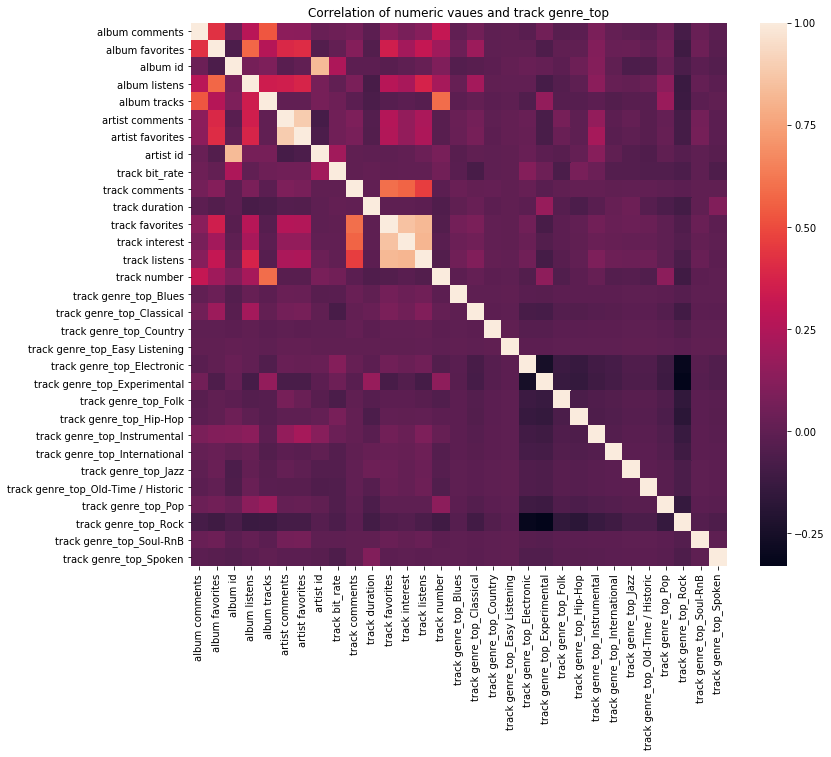

In [229]:
target_numeric_corr = target_numeric.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(target_numeric_corr);
plt.title('Correlation of numeric vaues and track genre_top')
plt.show()

In [270]:
target_numeric.columns.values
selected = target_numeric[['album favorites', 'album listens',
                           'album tracks', 'artist comments', 
                           'artist favorites', 'track bit_rate',
                           'track favorites', 'track interest', 
                           'track listens']]
selected = selected.join(tracks_categorical_2['track_genres_extracted'])
selected_reset = selected.reset_index(level = 'track_genres_matched')
selected_reset = selected_reset.join(
                      tracks_categorical_3.reset_index(level = 'track_genres_all_matched') \
                        ['track_genres_all_extracted'])
selected = selected_reset.copy()
selected = selected.join(tracks['track genre_top'])
selected.head()

,track_genres_matched,album favorites,album listens,album tracks,artist comments,artist favorites,track bit_rate,track favorites,track interest,track listens,track_genres_extracted,track_genres_all_extracted,track genre_top
track_id,,,,,,,,,,,,,
135,0,0,3331,4,1,0,256000,0,2484,1832,45,58,Rock
135,0,0,3331,4,1,0,256000,0,2484,1832,45,12,Rock
136,0,0,3331,4,1,0,256000,0,1948,1498,45,58,Rock
136,0,0,3331,4,1,0,256000,0,1948,1498,45,12,Rock
137,0,2,1681,2,0,5,256000,2,2559,1278,1,32,Experimental


In [271]:
log_regr(selected, max_iter = 100)

Logistic Regression:
  parameters: 
    multi-class: ovr 
    solver: liblinear 
    max_iter: 100
  score: 0.7190056976395494


In [250]:
log_regr(selected, multi_class = 'multinomial', solver = 'lbfgs',
        max_iter = 10000)

Logistic Regression:
  parameters: 
    multi-class: multinomial 
    solver: lbfgs 
    max_iter: 10000
  score: 0.57425609625094


In [273]:
log_regr(selected, multi_class = 'multinomial', solver = 'sag',
         max_iter = 10000)

Logistic Regression:
  parameters: 
    multi-class: multinomial 
    solver: sag 
    max_iter: 10000
  score: 0.634355052906653


## Analysis of the output
Answer the following questions (written, ~paragraph each):
  - What are the best predictors of genre?
    - Here are the best predictors of genre if we only consider numerical features:
      - track genres (with a correlation of 0.59)
      - track genres_all (with a correlation of 0.53)
      - set subset (is also high with a correlation of 0.27 to 0.37)

  - What information isn't very useful for predicting genre?
    - These have very little correlation with 'track genre_top':
      - track bitrate
      - track interest
      - track listens

  -  What surprised you the most about your results?
    - I didn't think there would be much of a correlation between any of these components and the 'track genre_top'.  It was surprising to see that there is enough correlation to still be able to predict the top genre with more than 50% accuracy.  The best result we got was a Logistic Regression score of 0.72

## Resources and stretch goals

- Check out the other .csv files from the FMA dataset, and see if you can join them or otherwise fit interesting models with them
- [Logistic regression from scratch in numpy](https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f) - if you want to dig in a bit more to both the code and math (also takes a gradient descent approach, introducing the logistic loss function)
- Create a visualization to show predictions of your model - ideally show a confidence interval based on error!
- Check out and compare classification models from scikit-learn, such as [SVM](https://scikit-learn.org/stable/modules/svm.html#classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html#classification), and [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html). The underlying math will vary significantly, but the API (how you write the code) and interpretation will actually be fairly similar.
- Sign up for [Kaggle](https://kaggle.com), and find a competition to try logistic regression with
- (Not logistic regression related) If you enjoyed the assignment, you may want to read up on [music informatics](https://en.wikipedia.org/wiki/Music_informatics), which is how those audio features were actually calculated. The FMA includes the actual raw audio, so (while this is more of a longterm project than a stretch goal, and won't fit in Colab) if you'd like you can check those out and see what sort of deeper analysis you can do.